##### Data Preparation
- check the columns which are required, which are not required.

In [ ]:
# drop that are not necessary : drop
cars = cars.drop('maker','model')

# selecting the field required : select
cars = cars.select('origin','type','cyl','size','weight','length','rpm','consumption')

#### Missing values 
- How to filter missing values ?
 - use filter
 - count() to know the count

In [ ]:
cars.filter('cyl IS NULL').count()

In [ ]:
# Use dropna() to drop all missing values
cars = cars.dropna()

#### Mutating columns

In [ ]:
from pyspark.sql.functions import round

# Create a new 'mass' columns
cars = cars.withColumn('mass', round(cars.weight/2.205, 0))

# convert length to metres.
cars = cars.withColumn('length', round(cars.length * 0.0254.3))

#### Indexing categorical data
- Indexing can be done using StringIndexer class.


In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol = 'type', OutputCol='type_idx')

# Assign index values to strings, use fit() method
indexer = indexer.fit(cars)

# create column with index values, use transform method
cars = indexer.transform(cars)

#### Use StringOrderType to change order of the index.

In [ ]:
# index country of origin USA -> 0 and non-USA -> 1
cars = StringIndexer(inputCol="origin", OutputCol="label").fit(cars).transform(cars)

#### Final Step:
- Assembling the columns 
    - consolidate various columns into one column.
    - this is because in spark- all machine learning alogithms work with single vector of predictors

In [ ]:
# Step1 : Create the instance of VectorAssembler class

from pyspark.ml.feature import VectorAssembler
assembler =  VectorAssembler(inputCols = ['cyl', 'size'], outputCol='features') # cyl and size are transformed

# transform the data of 
assembler.transform(cars)

In [ ]:
# Remove the 'flight' column
flights = flights.drop('flight')

# Number of records with missing 'delay' values
flights.filter('delay IS NULL').count()

# Remove records with missing 'delay' values
flights = flights.filter('delay IS NOT NULL')

# Remove records with missing values in any column and get the number of remaining rows
flights = flights.dropna()
print(flights.count())

In [ ]:
# Import the required function
from pyspark.sql.functions import round

# Convert 'mile' to 'km' and drop 'mile' column
flights_km = flights.withColumn('km', round(flights.mile * 1.690934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether flight delayed (1) or not (0)
flights_km = flights_km.withColumn('label', (flights_km.delay >=15).cast('integer'))

# Check first five records
flights_km.show(5)

In [ ]:
# Import the required function
from pyspark.sql.functions import round

# Convert 'mile' to 'km' and drop 'mile' column
flights_km = flights.withColumn('km', round(flights.mile * 1.690934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether flight delayed (1) or not (0)
flights_km = flights_km.withColumn('label', (flights_km.delay >=15).cast('integer'))

# Check first five records
flights_km.show(5)

In [ ]:
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(flights)

# Indexer creates a new column with numeric index values
flights_indexed = indexer_model.transform(flights)

# Repeat the process for the other categorical feature
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)

In [ ]:
# Import the necessary class
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'mon','dom','dow','carrier_idx', 'org_idx', 'km', 'depart', 'duration'
], outputCol='features')

# Consolidate predictor columns
flights_assembled = assembler.transform(flights)

# Check the resulting column
flights_assembled.select('features', 'delay').show(5, truncate=False)

#### Decision Tree
- A decision tree is constructed using an alogorithm called "Recursive Partitioning"
- Let us suppose we a node of colors called (green) and (blue)
- 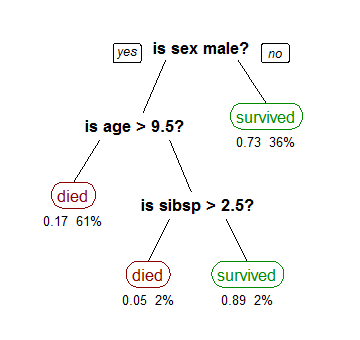
A decision tree is drawn upside down with its root at the top. In the image on the left, the bold text in black represents a condition/internal node, based on which the tree splits into branches/ edges. The end of the branch that doesn’t split anymore is the decision/leaf, in this case, whether the passenger died or survived, represented as red and green text respectively.
Although, a real dataset will have a lot more features and this will just be a branch in a much bigger tree, but you can’t ignore the simplicity of this algorithm. The feature importance is clear and relations can be viewed easily. This methodology is more commonly known as learning decision tree from data and above tree is called Classification tree as the target is to classify passenger as survived or died. Regression trees are represented in the same manner, just they predict continuous values like price of a house. In general, Decision Tree algorithms are referred to as CART or Classification and Regression Trees.
So, what is actually going on in the background? Growing a tree involves deciding on which features to choose and what conditions to use for splitting, along with knowing when to stop. As a tree generally grows arbitrarily, you will need to trim it down for it to look beautiful. Lets start with a common technique used for splitting.

#### Split train/test


In [ ]:
# Split data into training and testing sets
# specify a seed for reproducibility

cars_train, cars_test = cars.randomsplit([0.8, 0.2], seeds=23)

# cars_train, cars_test
cars_train.count(), cars_test.count()



In [ ]:
# Building Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier

# Create a Decision Tree Classifier
tree = DecisionTreeClassifier()

# Learn from the training data
tree = tree.fit(cars_train)

# Evaluating
# Make predictions on the testing data and compare to known values.
prediction  = tree.transform(cars_test)

# understanding performance of a model
# confusion matrix - is a table which describes performance of a model on testing data.
prediction.groupBy("label", "prediction").count().show()

# accuracy = (TN + TP) /( TN + TP + FN + FP) - proportion of correct predictions.
# True positive = TP
# True negative = TN
# False positive = FP
# False negative = FN

In [ ]:
# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights.randomSplit([0.8, 0.2], seed=17)

# Check that training set has around 80% of records
training_ratio = flights_train.count() / flights_test.count()
print(training_ratio)

In [ ]:
# Import the Decision Tree Classifier class
from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

In [ ]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = ((TN + TP) / (TN + TP + FN + FP))
print(accuracy)

In [ ]:
0.642

#### Logistic Regression
- Another classification.
- Logically denoted by 0 or 1 || true or False
- x-axis is linear (which is combination of values)
- y-axis is output of the model
- probablity of 0 or 1
- above the threshold which is naturally 1
- below the threshold which is naturally 0
- coefficient might shift the curve towards right or left.
- transition might be gradual, steep 



In [ ]:
# Preparing the model
# Assemble the predictors into a single columns (called features) and 
# split data into training and testing sets.

In [ ]:
# Building the logistic Regression
from pyspark.ml.classification import LogisticRegression

# Create a classifier object
logistic = LogisticRegression()

# Learn from the training data
logistic = logistic.fit(cars_train)

#Predictions
prediction = logistic.transform(cars_test)

#Accurancy
#Confusion matrix.
#Precision is the proportion of positive predictions to sum of True and False positives.

precision = TP/(TP + FP)

# Recall (positive)
recall  = TP/(TP + FN)

# Weighted metrics, will help you another kind prediction.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# evaluate
evaluator = MulticlassClassificationEvaluator()
evaluator.evaluate(prediction, {evaluator.metricName: 'weightedPrecision'})

#other metrics
# - weightedRecall
# - accuracy
# - f1

# varrying the threshold
# ROC or AUC

# ROC = 'Receiver Operating Characteristic'
# TP versus F
# threshold = 0 (top right)
# threshold = 1 (bottom left)


# AUC = 'Area under the curve'
# ideally AUC = 1

#### Build a Logistic Regression model
You've already built a Decision Tree model using the flights data. Now you're going to create a Logistic Regression model on the same data.

The objective is to predict whether a flight is likely to be delayed by at least 15 minutes (label 1) or not (label 0).

Although you have a variety of predictors at your disposal, you'll only use the mon, depart and duration columns for the moment. These are numerical features which can immediately be used for a Logistic Regression model. You'll need to do a little more work before you can include categorical features. Stay tuned!

The data have been split into training and testing sets and are available as flights_train and flights_test

In [ ]:
# Import the logistic regression class
from pyspark.ml.classification import LogisticRegression

# Create a classifier object and train on training data
logistic = LogisticRegression().fit(flights_train)

# Create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP / (TP + TN)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})